In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cpu_unpickler import CPU_Unpickler
from data import create_spiral
from torchmetrics import Accuracy
from models import SpiralModel
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim),
            nn.Sigmoid(),
        )

        self.mu = nn.Linear(z_dim, z_dim)
        self.logvar = nn.Linear(z_dim, z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction="sum")
    reconstruction_loss = MSE(recon_x, x)
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KL_divergence

In [3]:
with open("1_layer_models.pickle", "rb") as f:
    real_models = CPU_Unpickler(f).load()

class WeightsDataset(Dataset):
    def __init__(self, state_dicts):
        self.data = [self.flatten_state_dict(sd) for sd in state_dicts]

    def flatten_state_dict(self, state_dict):
        weight = state_dict["linearA.weight"].view(-1)
        bias = state_dict["linearA.bias"].view(-1)
        return torch.cat([weight, bias])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


train_dataset = WeightsDataset(real_models)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

sample = train_dataset[0]
x_dim = sample.size()[0]

Epoch: 0, Loss: 12.8577
Epoch: 1, Loss: 12.3636
Epoch: 2, Loss: 11.9630
Epoch: 3, Loss: 11.5186
Epoch: 4, Loss: 11.1387
Epoch: 5, Loss: 10.6882
Epoch: 6, Loss: 10.1547
Epoch: 7, Loss: 9.8573
Epoch: 8, Loss: 9.3396
Epoch: 9, Loss: 9.0211
Epoch: 10, Loss: 8.7059
Epoch: 11, Loss: 8.3246
Epoch: 12, Loss: 8.0887
Epoch: 13, Loss: 7.8562
Epoch: 14, Loss: 7.6875
Epoch: 15, Loss: 7.6003
Epoch: 16, Loss: 7.4684
Epoch: 17, Loss: 7.3139
Epoch: 18, Loss: 7.2393
Epoch: 19, Loss: 7.0765
Epoch: 20, Loss: 7.1266
Epoch: 21, Loss: 6.9092
Epoch: 22, Loss: 6.8841
Epoch: 23, Loss: 6.8597
Epoch: 24, Loss: 6.8230
Epoch: 25, Loss: 6.7770
Epoch: 26, Loss: 6.6974
Epoch: 27, Loss: 6.6153
Epoch: 28, Loss: 6.5844
Epoch: 29, Loss: 6.5962
Epoch: 30, Loss: 6.5534
Epoch: 31, Loss: 6.4715
Epoch: 32, Loss: 6.3897
Epoch: 33, Loss: 6.4350
Epoch: 34, Loss: 6.3465
Epoch: 35, Loss: 6.3900
Epoch: 36, Loss: 6.3597
Epoch: 37, Loss: 6.3225
Epoch: 38, Loss: 6.3046
Epoch: 39, Loss: 6.2660
Epoch: 40, Loss: 6.2127
Epoch: 41, Loss: 6.

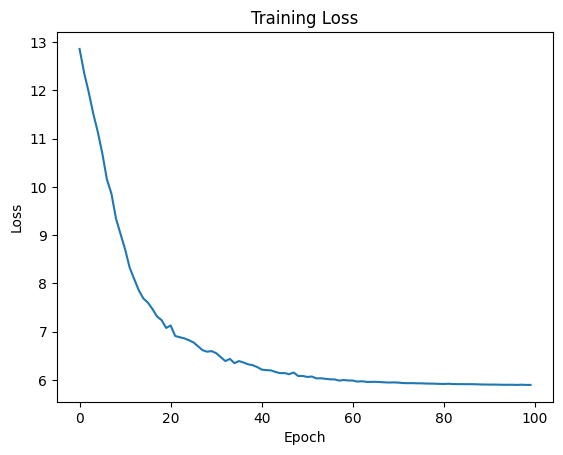

In [4]:
z_dim = 16
vae = VAE(x_dim=x_dim, hidden_dim=32, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
losses = []
epochs = 100
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    print("Epoch: {}, Loss: {:.4f}".format(epoch, avg_loss))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [5]:
X, y = create_spiral(N=500, gamma=0.2)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

0.5133
0.5167
0.5133
0.5167
0.5167
0.5133
0.5200
0.5133
0.5133
0.5167
0.5167
0.5100
0.5167
0.5133
0.5167
0.5167
0.5200
0.5167
0.5167
0.5200
0.5167
0.5133
0.5167
0.5200
0.5133
0.5167
0.5133
0.5133
0.5100
0.5200
0.5167
0.5167
0.5200
0.5167
0.5100
0.5200
0.5133
0.5133
0.5200
0.5133
0.5133
0.5133
0.5167
0.5167
0.5200
0.5133
0.5100
0.5133
0.5133
0.5100
0.5133
0.5133
0.5133
0.5167
0.5167
0.5200
0.5133
0.5167
0.5167
0.5100
0.5167
0.5167
0.5133
0.5133
0.5200
0.5167
0.5167
0.5167
0.5167
0.5133
0.5133
0.5133
0.5167
0.5200
0.5167
0.5200
0.5200
0.5200
0.5133
0.5167
0.5167
0.5167
0.5233
0.5133
0.5133
0.5167
0.5133
0.5133
0.5167
0.5133
0.5133
0.5167
0.5167
0.5167
0.5100
0.5133
0.5167
0.5167
0.5133
0.5133
0.5100
0.5200
0.5100
0.5133
0.5167
0.5133
0.5167
0.5100
0.5167
0.5133
0.5167
0.5167
0.5167
0.5133
0.5200
0.5200
0.5200
0.5133
0.5133
0.5167
0.5200
0.5133
0.5167
0.5233
0.5167
0.5100
0.5200
0.5133
0.5167
0.5133
0.5167
0.5167
0.5200
0.5167
0.5133
0.5200
0.5200
0.5167
0.5167
0.5100
0.5100
0.5133
0.5133

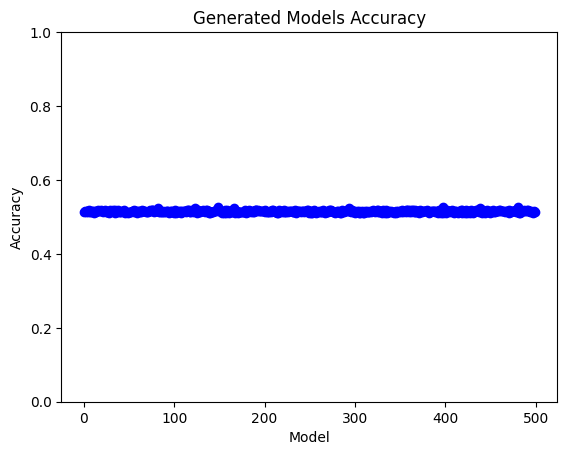

Mean accuracy: 0.5155, Std: 0.0033


In [6]:
num_of_models = len(real_models)

generated_tensors = []
with torch.no_grad():
    z = torch.randn(num_of_models, z_dim).to(device)
    vae.eval()
    w_hats = vae.decoder(z)

temp_model = SpiralModel().to(device)
weight_shape = temp_model.linearA.weight.shape
bias_shape = temp_model.linearA.bias.shape
w1_len = torch.prod(torch.tensor(weight_shape)).item()
generated_models = []
for i in range(num_of_models):
    weight_hat = w_hats[i]
    w1 = weight_hat[:w1_len].view(weight_shape)
    b1 = weight_hat[w1_len:].view(bias_shape)
    new_state_dict = {
        "linearA.weight": w1,
        "linearA.bias": b1,
    }
    generated_models.append(new_state_dict)


acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

accuracies = []
for i, state_dict in enumerate(generated_models):
    model = SpiralModel().to(device)
    model.load_state_dict(state_dict)
    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_acc = acc_fn(test_pred, y_test).item()
        accuracies.append(test_acc)
        print(f"{test_acc:.4f}")

        plt.scatter(i, test_acc, color="blue", marker="o")

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim([0, 1.0])
plt.title("Generated Models Accuracy")
plt.show()

mean_acc = torch.tensor(accuracies).mean().item()
std_acc = torch.tensor(accuracies).std().item()

print(f"Mean accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

In [7]:
with open("1_layer_generated_models.pickle", "wb") as f:
    pickle.dump(generated_models, f)

In [8]:
torch.save(vae.state_dict(), "1_layer_vae.pt")